In [1]:
import numpy as np
import argparse
import os,sys
sys.path.append('../')
from os.path import join
import glob
import  random
import scipy
from scipy import spatial
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
# from face2speaker_main import Face2Speaker
# from Recode.model import DoubleLayerModel, SingleLayerModel
from senet import *
from model import *
from PIL import Image
from torchvision import transforms
from time import time

In [2]:
random.seed(0)

class Evaluation():
    def __init__(self, 
                root, 
                embedder,
                num_queries=100, 
                gallery_size=5, 
                distance_metric='euclidean'):

        self.embedder = embedder
        self.root = root
        self.gallery_size = gallery_size
        self.num_queries = num_queries
        self.distance_metric= distance_metric
        self.generate_eval_data()
        pass

    def distance(self,a,b):
        if self.distance_metric=='euclidean':
            return np.linalg.norm(a-b)
        elif self.distance_metric=='cosine':
            return spatial.distance.cosine(a,b)

    def generate_eval_data(self):
        _id_list = sorted(os.listdir(self.root))

        queries = []
        final_gallery = []

        for _id in sorted(os.listdir(self.root)):
            _id_path = join(self.root, _id)
            for _url in sorted(os.listdir(_id_path)):
                _url_path = join(_id_path,_url)
                listOfDirs=[f for f in os.listdir(_url_path) if os.path.isdir(join(_url_path, f))]
                for dir in sorted(listOfDirs):
                    emb_dir = join(_url_path,dir)
                    if os.listdir(emb_dir):
                        queries.append(join(emb_dir, random.choice(sorted(os.listdir(emb_dir)))))
        random.shuffle(queries)
        for _idx, query in enumerate(queries[0:self.num_queries]):
            _id = query.split(os.sep)[-4]
            same_flag = 1

            while same_flag:
                answer_set = glob.glob(join(self.root, _id, join('*','*.jpg')))

                answer = random.choice(answer_set)
                if(not answer.split(os.sep)[-2]==query.split(os.sep)[-3]):
                    same_flag = 0
                
            diff_speakers = [i for i in _id_list if i!=_id]
            random.shuffle(diff_speakers)

            assert not _id in diff_speakers

            impostor_gallery = [] 
            
            for imp in diff_speakers[0:self.gallery_size-1]:
                imp_embeddings = glob.glob(join(self.root,imp,join('*','*.jpg')))
                impostor_gallery.append(random.choice(imp_embeddings))
                
            impostor_gallery.append(answer)
            final_gallery.append(impostor_gallery)
            
        self.queries = np.array(queries[0:self.num_queries])
        self.galleries = np.array(final_gallery[0:self.num_queries])
        self.answer = np.array([self.gallery_size-1]*self.num_queries)
        # print("self.queries", self.queries)
        # print("self.galleries", self.galleries)
        print("Num queries : %d"%(len(self.queries)))
        print("Gallery Size : %d"%(self.galleries.shape[1]))
        pass

    def evaluate(self):

        test_samples = self.num_queries

        result = []
        
        for _idx, query in enumerate(self.queries[0:test_samples]):
            distances=[]
            for toMatch in self.galleries[_idx]:
                face_emb, audio_emb=self.embedder.get_embedding(input_path_pair=(toMatch, query))
                distances.append(self.distance(face_emb, audio_emb))
            result.append(np.argmin(distances))    
            
        result = np.array(result)
        r = len(np.where(result==self.answer[0:test_samples])[0])
        accuracy = r/test_samples
        print("Identification Accuracy : %.4f"%(accuracy))
        return accuracy


In [3]:
class GetEmbeddings():
    def __init__(self, 
                 learnable_pins_model):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.learnable_pins_model = learnable_pins_model 
        self.learnable_pins_model.to(self.device)
        if torch.cuda.device_count() > 1:
            self.learnable_pins_model = nn.DataParallel(self.learnable_pins_model) 
        # self.learnable_pins_model.test()
        self.learnable_pins_model.eval()
        
    def get_embedding(self, input_path_pair=None, emb=None):
        if input_path_pair[0] is not None and input_path_pair[1] is not None:
            transformToTensor = transforms.ToTensor()         
            face_frame = Image.open(input_path_pair[0]).convert('RGB')
            audio_fft = np.load(input_path_pair[1])
        img_transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(brightness=0.5, hue=0.3),
            transforms.ToTensor(),
        ])
        display(face_frame)
        face_frame = img_transform(face_frame).unsqueeze(0)
        face_frame = face_frame.to(self.device)

        audio_fft = transformToTensor(audio_fft).unsqueeze(0)
        audio_fft = audio_fft.to(self.device)
        
        # face_emb /= np.linalg.norm(face_emb)
        # face_emb = torch.from_numpy(face_emb).unsqueeze(0)
        # face_emb = face_emb.to(self.device)


        # audio_emb /= np.linalg.norm(audio_emb)
        # audio_emb = torch.from_numpy(audio_emb).unsqueeze(0)
        # audio_emb = audio_emb.to(self.device)
        with torch.no_grad():
            res_face_emb, res_audio_emb = self.learnable_pins_model(face_frame, audio_fft)
        res_audio_emb = res_audio_emb.cpu().numpy().reshape(-1)
        res_face_emb = res_face_emb.cpu().numpy().reshape(-1)

        return res_face_emb, res_audio_emb


senet
Weights Loaded!


  0%|          | 0/9 [00:00<?, ?it/s]

Num queries : 1000
Gallery Size : 2


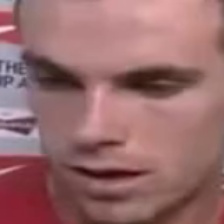

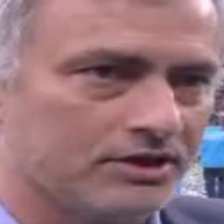

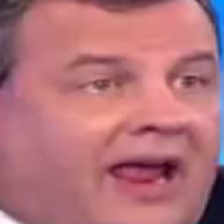

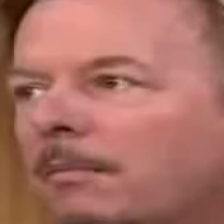

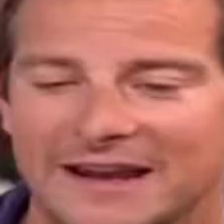

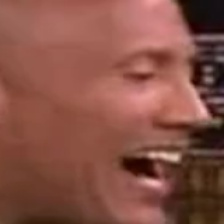

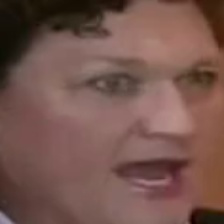

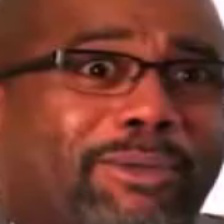

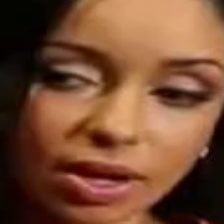

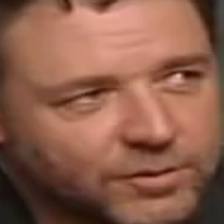

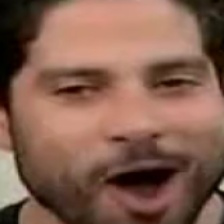

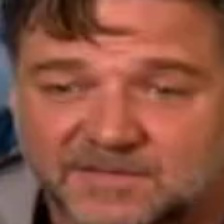

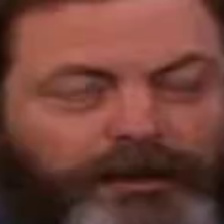

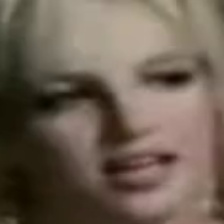

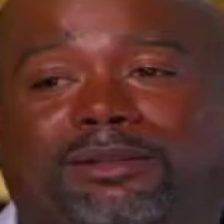

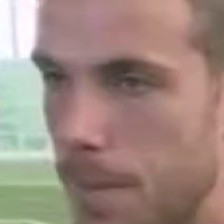

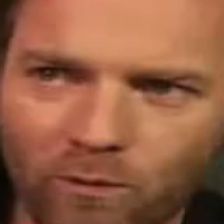

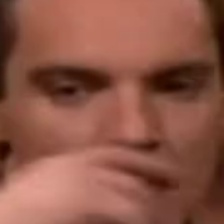

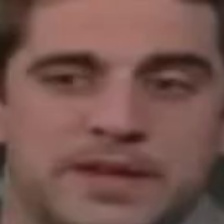

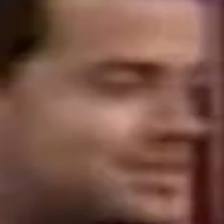

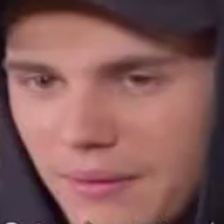

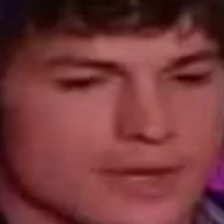

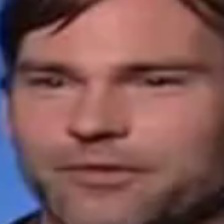

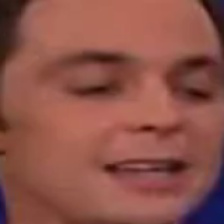

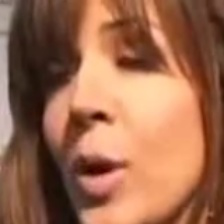

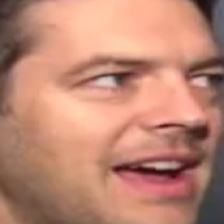

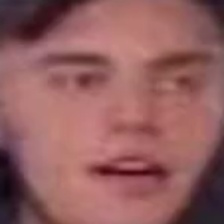

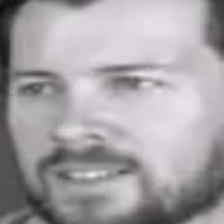

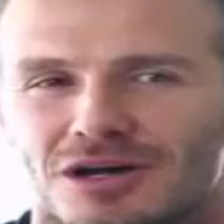

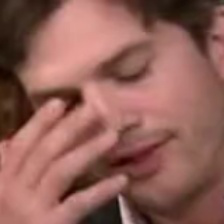

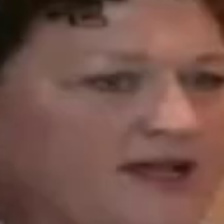

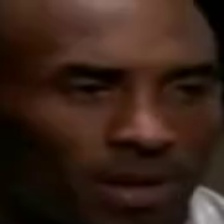

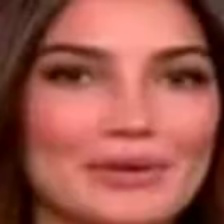

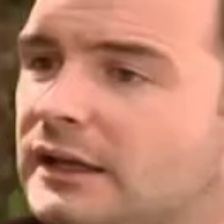

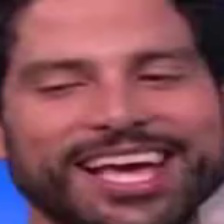

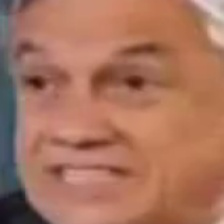

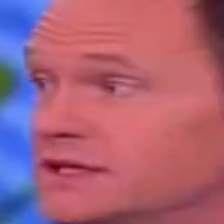

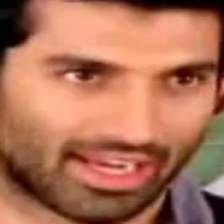

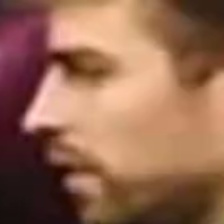

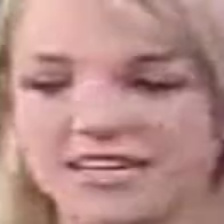

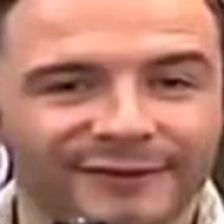

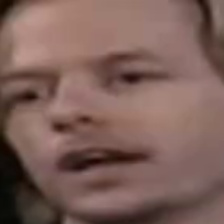

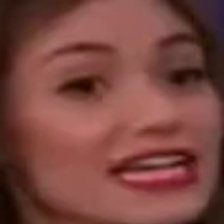

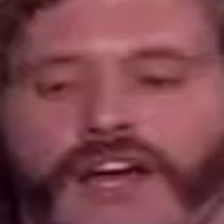

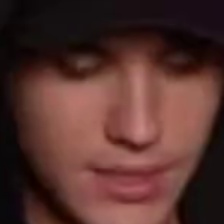

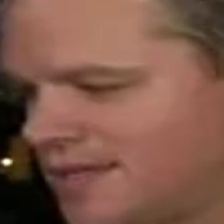

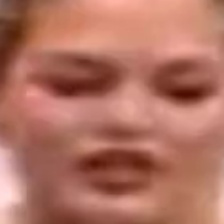

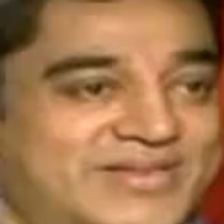

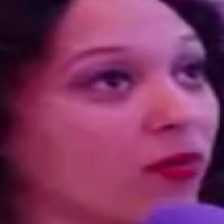

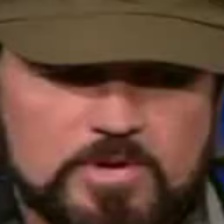

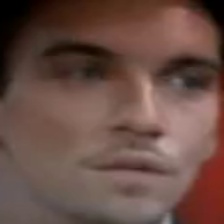

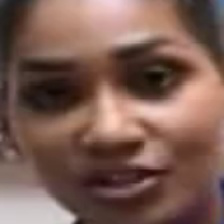

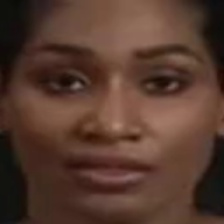

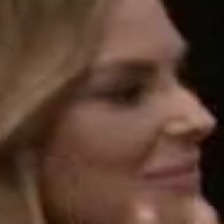

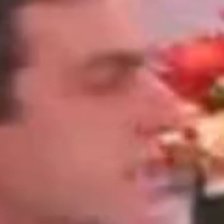

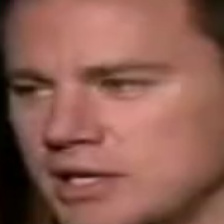

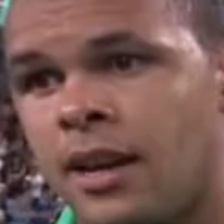

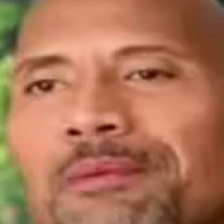

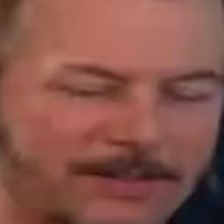

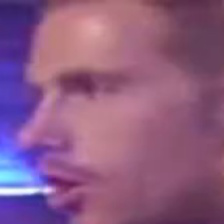

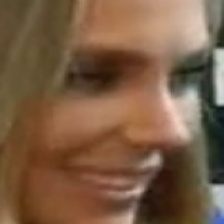

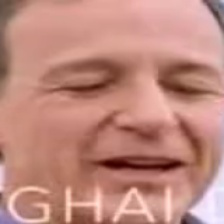

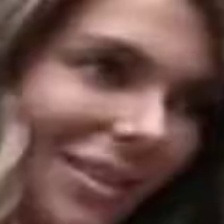

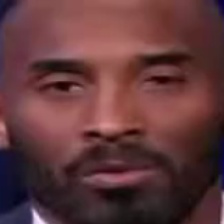

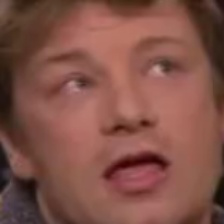

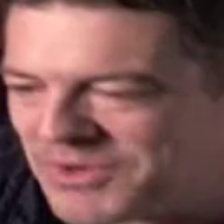

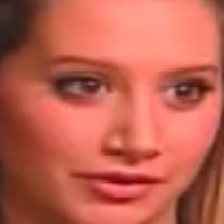

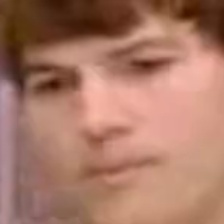

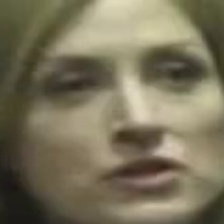

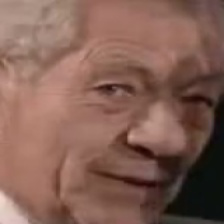

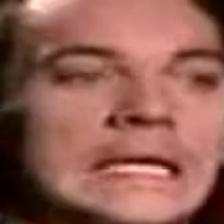

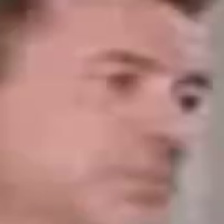

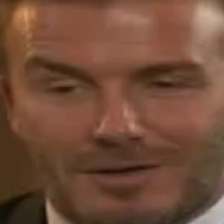

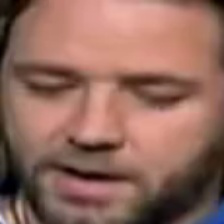

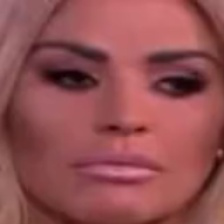

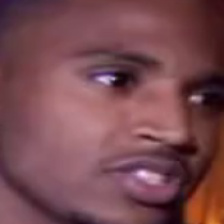

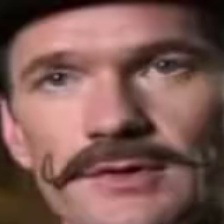

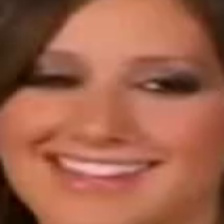

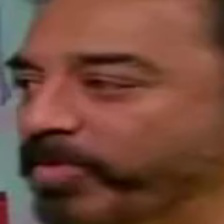

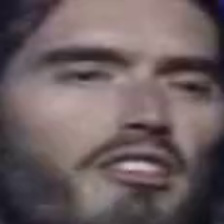

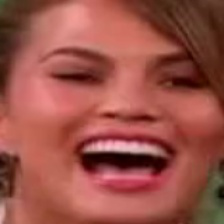

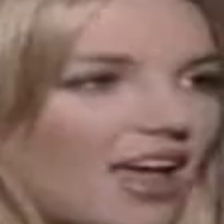

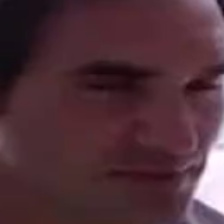

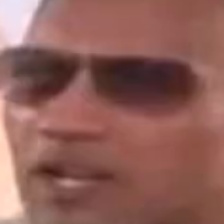

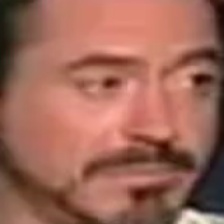

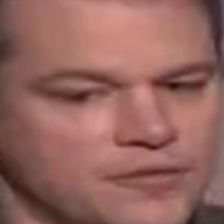

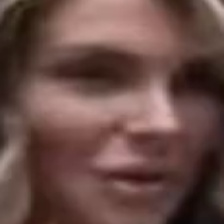

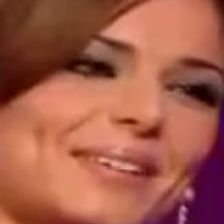

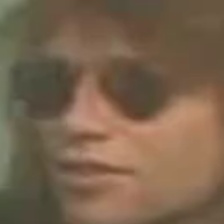

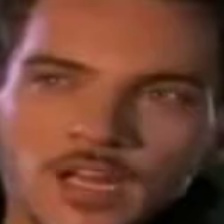

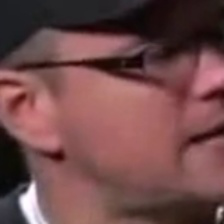

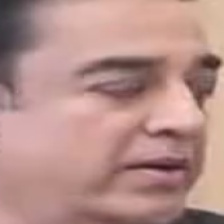

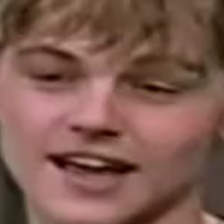

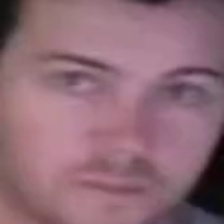

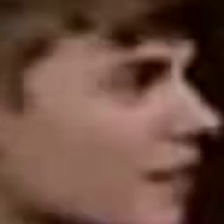

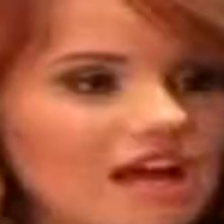

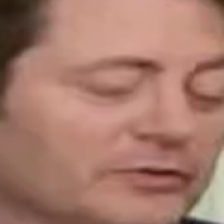

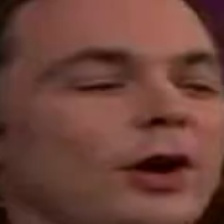

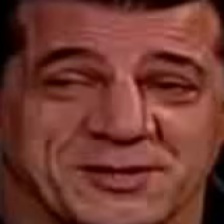

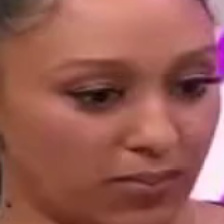

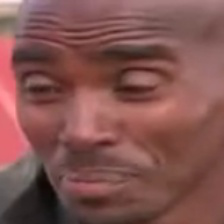

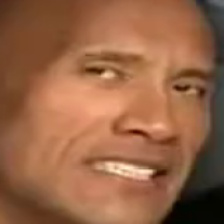

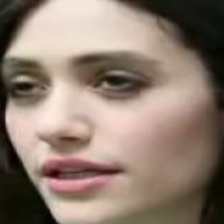

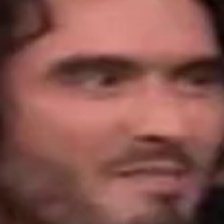

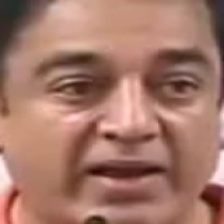

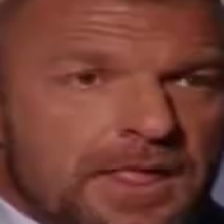

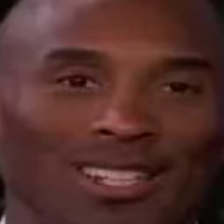

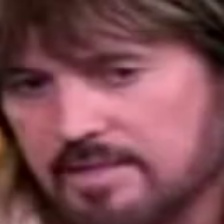

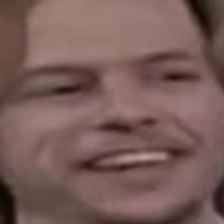

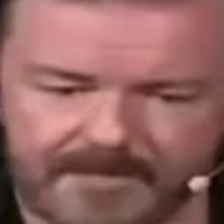

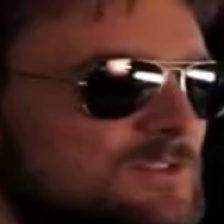

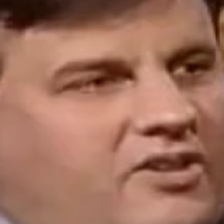

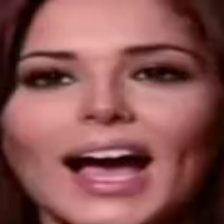

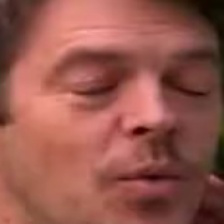

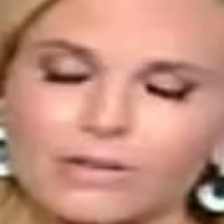

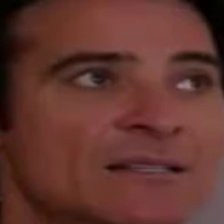

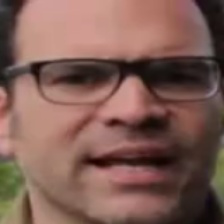

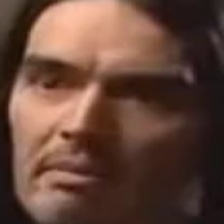

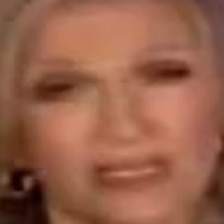

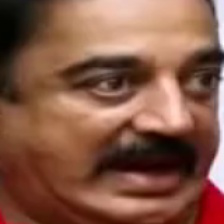

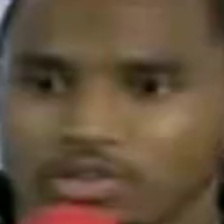

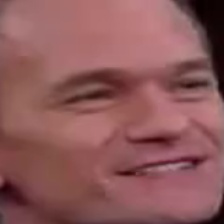

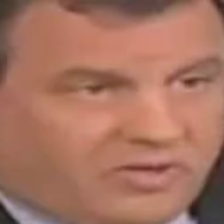

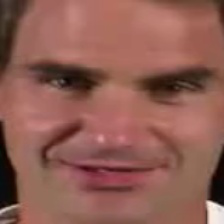

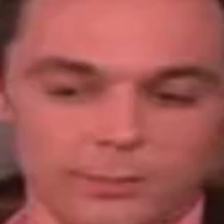

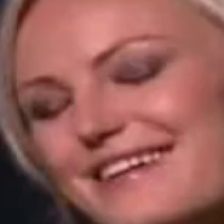

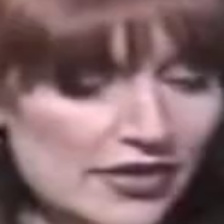

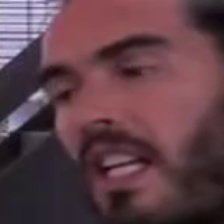

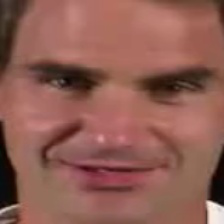

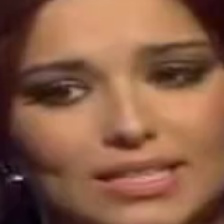

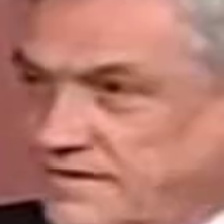

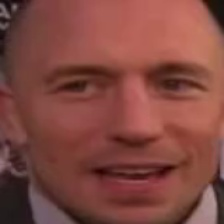

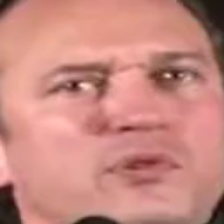

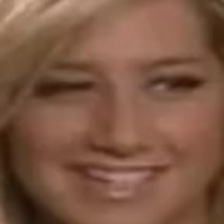

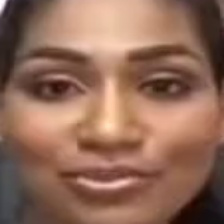

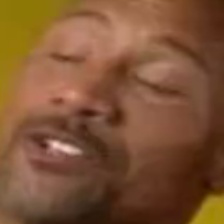

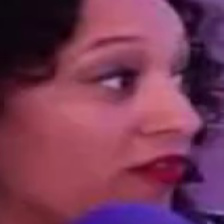

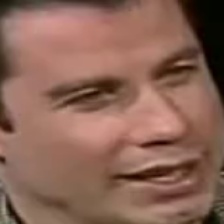

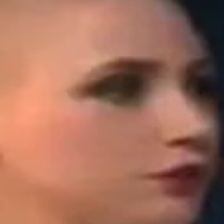

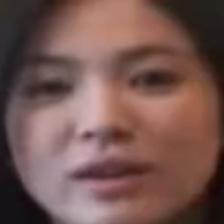

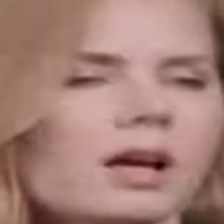

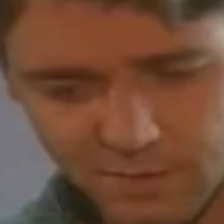

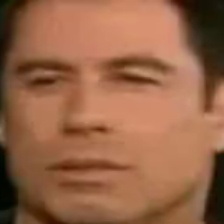

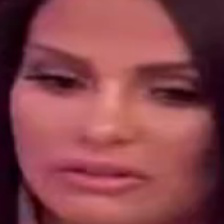

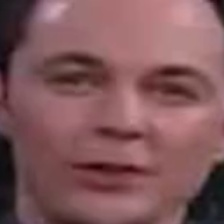

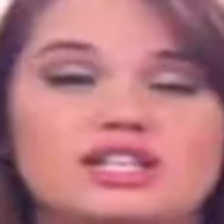

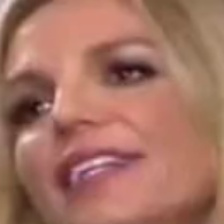

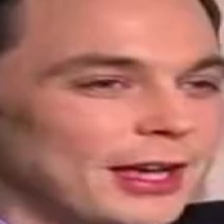

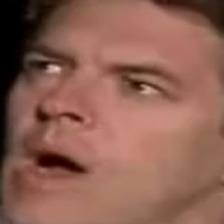

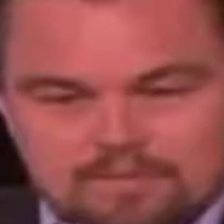

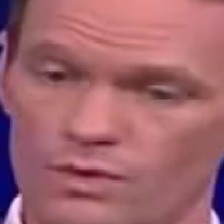

  0%|          | 0/9 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [4]:
def run_evaluate(root="/scratch/starc52/VoxCeleb2/test/mp4/", model_path=join('/ssd_scratch/cvit/starc52/LPscheckpoints','model_e1.pth')):
    test_root = root

    model = LearnablePINSenetVggVox256()
    model.test()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
#     model.load_state_dict(torch.load(model_path)['model_state_dict'])

    embedder = GetEmbeddings(learnable_pins_model=model)


    acc_arr = []
    for i in tqdm(range(2, 11)):
        evaluation = Evaluation(root=test_root, embedder=embedder,gallery_size=i,num_queries=1000)

        acc = evaluation.evaluate()
        acc_arr.append(acc)

    return acc_arr


def run_multiple_epochs(root="/scratch/starc52/VoxCeleb2/", model_path = "/ssd_scratch/cvit/starc52/LPscheckpoints/"):
    listOfPaths = ['test/mp4', 'dev/mp4']
    listOfModels= [os.path.join(model_path, "model_e"+str(num)+".pth") for num in range(30, 50)]
    listOfAccuracies={}
    for idx, path in enumerate(tqdm(listOfModels)):
        acc_arr={}
        for pathAdd in listOfPaths:
            print("set, model:", os.path.join(root, pathAdd), path)
            acc_arr[pathAdd.split('/')[0]] = run_evaluate(root=os.path.join(root, pathAdd), model_path=path)
            listOfAccuracies[path.replace("/", "-")] = acc_arr
            print(acc_arr)
    os.makedirs("/home/starc52/audret/graphs", exist_ok=True)
    for model in listOfAccuracies:
        for dataset in model:
            plt.plot(np.arange(0, len(listOfAccuracies[model[dataset]]))+2, listOfAccuracies[model[dataset]], label=dataset)
        plt.xlabel('Gallery Size')
        plt.ylabel('Identification Accuracy')
        plt.title('1:N F-V matching')
        plt.grid()
        plt.legend()
        plt.savefig('/home/starc52/audret/graphs/'+str(model)+'_nor.png')
        plt.clf()
    # maxList = max(listOfAccuracies, key=lambda x: x[0])
    # maxPath=[listOfModels[listOfAccuracies.index(maxList)]]
    # print(list(zip(listOfModels, listOfAccuracies)))
    # print(list(zip(maxPath, [maxList])))
    # for idx, path in enumerate(maxPath):
    #     plt.plot(np.arange(0,len(maxList))+2,maxList, label=path[-7:-4])
    # plt.xlabel('Gallery Size')
    # plt.ylabel('Identification Accuracy')
    # plt.title('1:N F-V matching')
    # plt.grid()
    # plt.legend()
    # plt.savefig('/home/starc52/audret/retrieve_'+root.split("/")[-2]+'_graph.png')
    # plt.clf()
    # plt.show()
# parser = argparse.ArgumentParser()
# parser.add_argument('--root',default='/scratch/starc52/VoxCeleb2/', type=str)
# args = parser.parse_args()
if __name__ == '__main__':
    test_acc=run_evaluate(root="/scratch/starc52/VoxCeleb2/test/mp4", model_path=join('/ssd_scratch/cvit/starc52/LPscheckpoints/', 'model_e43.pth'))
    dev_acc=run_evaluate(root="/scratch/starc52/VoxCeleb2/dev/mp4", model_path=join('/ssd_scratch/cvit/starc52/LPscheckpoints/', 'model_e43.pth'))
    plt.plot(np.arange(0, len(test_acc))+2, test_acc, label="test")
    plt.plot(np.arange(0, len(dev_acc))+2, dev_acc, label="dev")
    plt.xlabel('Gallery Size')
    plt.ylabel('Identification Accuracy')
    plt.title('1:N F-V matching')
    plt.grid()
    plt.legend()
    plt.savefig('/home/starc52/audret/graphs/epoch_43.png')
    plt.clf()
    # run_multiple_epochs(root=args.root)

